In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from behav import plotting, utils, loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
pd.set_option('display.max_columns', 500)
import seaborn as sns

/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """


In [3]:
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'
%matplotlib inline

In [4]:
from cdcp.experiment_info import subjects
from cdcp.paths import DATA_PATH_MAGPI
from cdcp.behavior.data import prepare_behavior_data
from cdcp.visualization.colors import colors
subjects, DATA_PATH_MAGPI
from cdcp.paths import DATA_PATH_MAGPI, FIGURE_DIR, ensure_dir
from cdcp.general import save_fig

In [5]:
import scipy.stats

In [6]:
from cdcp.visualization.colors import colors as cdcp_colors

In [7]:
from cdcp.behavior.data import bin_data, cue_direction

## Plot relationship between reaction time and stimulus

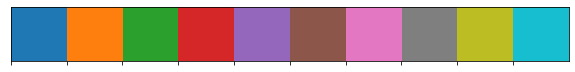

In [8]:
pal = sns.color_palette('tab10', 10)
sns.palplot(pal)

In [9]:
## Runs the plotting code on my data
#behav_data = loading.load_data_pandas(subjects,DATA_PATH_MAGPI)
#for key, value in tqdm(behav_data.items(), total = len(behav_data)):
#    behav_data[key], bins = prepare_behavior_data(value, num_bins=25)

### load data

In [10]:
def prepare_behavior_data(data, num_bins=16, num_prev=np.inf):
    """ parses information from raw bahav_data dataframes
    """
    # subset normal trials
    data = data[data["response"] != "none"]
    
    # Subset part of the dataset
    if num_prev != np.inf:
        data = data[-num_prev:]

    # Extract the response as a boolean
    data["response_bool"] = 0
    data.loc[data["response"] == "L", "response_bool"] = 1
    
    # flip interpolation 0-127 so 0 corresponds to left, and 127 corresponds to right (to make it easier to read)
    data['interpolation_point'] = 127 - data['interpolation_point']
    data['response_bool'] = 1 - data['response_bool'] 

    # specify interpolation info
    data["interpolation"] = [
        ls + rs for ls, rs in zip(data.left_stim.values, data.right_stim.values)
    ]

    # bin data into 32 equally sized bins
    data["pos_bin"], bins = bin_data(
        data["interpolation_point"].values.astype("float32"), num_bins
    )
    data["cue_direction"] = data.cue_id.apply(cue_direction)
    return data, bins

In [11]:
# grab the final nex trials for each subject
total_trials = 0
nex = 100000
behav_data_all = []
for subject in tqdm(subjects):
    # load data
    behav_data_subject = loading.load_data_pandas([subject],DATA_PATH_MAGPI)[subject]
    # prep dataset
    behav_data_subject, bins = prepare_behavior_data(behav_data_subject, num_bins=32)
    
    # get trial count
    print(subject, len(behav_data_subject))
    total_trials += len(behav_data_subject)
    
    behav_data_subject = behav_data_subject[behav_data_subject.rt.isnull()==False]
    
    # skip first 20k traials where bird is still learning task
    if len(behav_data_subject) < nex:
        behav_data_subject = behav_data_subject[20000:]
        
    # get the most recent NEX trials
    behav_data_subject = behav_data_subject[-nex:]
    behav_data_subject['subject'] = subject
    behav_data_all.append(behav_data_subject)
behav_data_all = pd.concat(behav_data_all)
behav_data_all = behav_data_all[behav_data_all.rt >= 0]

  0%|          | 0/20 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/ipykernel_launcher.py:7: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  import sys
/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

B1174 444899
B1426 424782


/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/ipykernel_launcher.py:7: DtypeWarning: Columns (8,9,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  import sys


B1170 586050
B1432 822151
B1437 108765
B1433 227809
B1597 271881
B1427 457989
B1188 99807
B1244 301779
B1590 215348
B1399 147911
B1591 189463
B1252 231626
B1110 163466
B1390 156954
B1248 224734
B1593 394567
B1595 120982
B1276 203416


### norm mean from reaction time to account for side bias

In [12]:
def z_score(x):
    return (x - np.nanmean(x)) / np.nanstd(x)

In [13]:
behav_data_all["normed_rt"] = np.nan
for subject in tqdm(behav_data_all.subject.unique()):
    # based on animal dectsion
    behav_data_all.loc[
        (behav_data_all.subject.values == subject) & (behav_data_all.response.values == "L"),
        "normed_rt_decision",
    ] = z_score(
        behav_data_all.loc[
            (behav_data_all.subject.values == subject) & (behav_data_all.response.values == "L"),
            "rt",
        ]
    )
    
    behav_data_all.loc[
        (behav_data_all.subject.values == subject) & (behav_data_all.response.values == "R"),
        "normed_rt_decision",
    ] = z_score(
        behav_data_all.loc[
            (behav_data_all.subject.values == subject) & (behav_data_all.response.values == "R"),
            "rt",
        ]
    )
    
    # based on actual side
    behav_data_all.loc[
        (behav_data_all.subject.values == subject) & (behav_data_all.class_.values == "L"),
        "normed_rt_class",
    ] = z_score(
        behav_data_all.loc[
            (behav_data_all.subject.values == subject) & (behav_data_all.class_.values == "L"),
            "rt",
        ]
    )
    
    behav_data_all.loc[
        (behav_data_all.subject.values == subject) & (behav_data_all.class_.values == "R"),
        "normed_rt_class",
    ] = z_score(
        behav_data_all.loc[
            (behav_data_all.subject.values == subject) & (behav_data_all.class_.values == "R"),
            "rt",
        ]
    )

  0%|          | 0/20 [00:00<?, ?it/s]

In [14]:
behav_data_all[:3]

,session,index,type_,stimulus,class_,response,correct,rt,reward,punish,cue_class,cue_id,cue_prob,num_stims,flip_cues,binary_choice,cueing,left_stim,right_stim,interpolation_point,prob_cue,prob_cued_no_cue,data_file,response_bool,interpolation,pos_bin,cue_direction,subject,self_initiated,normed_rt,normed_rt_decision,normed_rt_class
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-24 14:44:30.569983,709,52,normal,/home/bird/opdat/B1174/stimuli/AE/CL1/CL1_AE_1...,L,L,True,0.078940,False,False,CL,CL1,0.875,3,False,False,True,A,E,20,0.8,0.2,/mnt/cube/RawData/Magpi/B1174/B1174_trialdata_...,0,AE,5,L,B1174,NaN,NaN,-0.547038,-0.548247
2019-12-24 14:44:35.027883,709,53,normal,/home/bird/opdat/B1174/stimuli/BF/NC/NC_BF_110...,L,L,True,0.391212,False,False,NC,NC,0.500,3,False,False,True,B,F,17,0.8,0.2,/mnt/cube/RawData/Magpi/B1174/B1174_trialdata_...,0,BF,5,N,B1174,NaN,NaN,-0.024007,-0.017190
2019-12-24 14:44:38.697615,709,54,normal,/home/bird/opdat/B1174/stimuli/BE/CL1/CL1_BE_0...,L,L,True,0.000671,True,False,CL,CL1,0.875,3,False,False,True,B,E,40,0.8,0.2,/mnt/cube/RawData/Magpi/B1174/B1174_trialdata_...,0,BE,10,L,B1174,NaN,NaN,-0.678132,-0.681353


In [15]:
rt_correct = behav_data_all[behav_data_all.correct == True].rt.values
rt_incorrect = behav_data_all[behav_data_all.correct == False].rt.values

In [73]:
len(rt_correct) + len(rt_incorrect)

1979805

In [16]:
np.mean(rt_correct)

0.625421024251124

In [17]:
np.mean(rt_incorrect)

0.9818303423072469

In [18]:
scipy.stats.ttest_ind(rt_correct, rt_incorrect)

Ttest_indResult(statistic=-224.40226078473435, pvalue=0.0)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


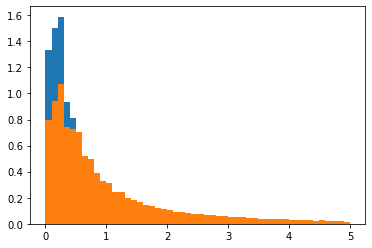

In [19]:
plt.hist(rt_correct, density=True, bins=50)
plt.hist(rt_incorrect, density=True, bins=50);

In [20]:
from scipy.ndimage import gaussian_filter1d

In [21]:
bins = np.linspace(0,5, 500)
#bins = np.logspace(-1,0.6989700043360189, 500, base=10)
bins[[0, -1]]

array([0., 5.])

In [22]:
correct_density, correct_bin = np.histogram(rt_correct, bins=bins, density=True)
incorrect_density, incorrect_bin = np.histogram(rt_incorrect, bins=bins, density=True)
correct_density = correct_density / np.sum(correct_density)
incorrect_density = incorrect_density / np.sum(incorrect_density)

In [23]:
np.max(correct_density)

0.04858252541185873

In [24]:
correct_gauss_100 = gaussian_filter1d(correct_density, sigma = 5)
incorrect_gauss_100 = gaussian_filter1d(incorrect_density, sigma = 5)

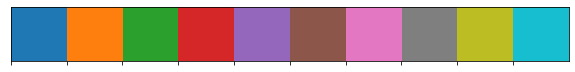

In [25]:
pal = sns.color_palette('tab10', 10)
sns.palplot(pal)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


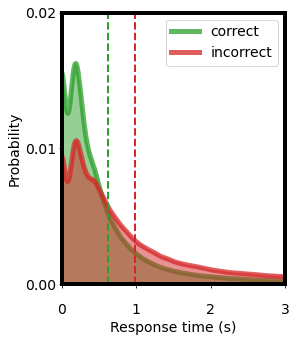

In [26]:
fig, ax = plt.subplots(figsize=(4,5))
x = bins[:-1]
floor = np.zeros(len(correct_gauss_100))
ax.fill_between(x, floor, correct_gauss_100, color=pal[2], alpha = 0.5, zorder=1)
ax.plot(x, correct_gauss_100, color = pal[2], lw=5, alpha = 0.75, label='correct', zorder=1)

ax.fill_between(x, floor, incorrect_gauss_100, color=pal[3], alpha = 0.5, zorder=2)
ax.plot(x, incorrect_gauss_100, color = pal[3], lw=5, alpha = 0.75, label='incorrect', zorder=2)
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_ylim([1e-2,2])
ax.legend(fontsize=14)
ax.set_xlim([0,3])
ax.set_ylim([0, 0.0175])
ax.set_yticks([0, 0.01, 0.02])
ax.yaxis.labelpad = 4
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(4)
    ax.spines[axis].set_color("k")
ax.tick_params(axis="both", labelsize=14, pad=15)
ax.set_ylabel("Probability", fontsize=14)
ax.set_xlabel("Response time (s)", fontsize=14)


for tick in ax.get_yaxis().get_major_ticks():
    tick.set_pad(2.)
    
ax.axvline(np.mean(rt_correct), color = pal[2], lw=2, ls='dashed')
ax.axvline(np.mean(rt_incorrect), color = pal[3], lw=2, ls='dashed')
    
ensure_dir(FIGURE_DIR / 'behavioral_results')
save_fig(FIGURE_DIR / 'behavioral_results' / 'response-time-correct', save_pdf=True)
plt.show()

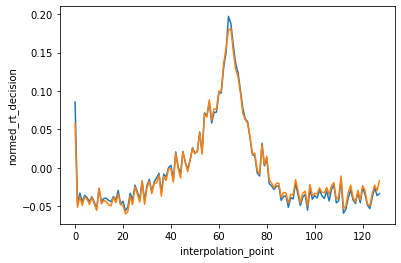

In [27]:
# plot difference between norming by class vs decision
fig, ax = plt.subplots()
sns.lineplot(x='interpolation_point', y='normed_rt_decision', data = behav_data_all, ci = None, ax = ax)
sns.lineplot(x='interpolation_point', y='normed_rt_class', data = behav_data_all, ax = ax, ci = None)
plt.show()


In [28]:
#bins = np.linspace(0,127, 32)
#behav_data_all['interpolation_bin'] = np.digitize(behav_data_all.interpolation_point, bins)
behav_data_all['interpolation_bin'] = behav_data_all['pos_bin']

In [29]:
rt_column = "normed_rt_class"
#rt_col = "rt"

In [30]:
# sort birds by rt differences
rt_by_interp_list = []
for axi, subject in enumerate(tqdm(behav_data_all.subject.unique())):
    behav_data_bird = behav_data_all[behav_data_all.subject == subject]
    x = np.abs(behav_data_bird.interpolation_bin.values - 16)
    y = behav_data_bird.normed_rt_class.values
    r2, p = scipy.stats.pearsonr(x,y)
    print(subject, r2, p)
    rt_by_interp_list.append([subject, r2, p])
rt_by_interp_df = pd.DataFrame(rt_by_interp_list, columns = ['subject','r2', 'p'])

  0%|          | 0/20 [00:00<?, ?it/s]

B1174 -0.057361940660209304 1.1903586855657591e-73
B1426 0.037970645190239787 3.092099511806758e-33
B1170 -0.03146619603899932 2.4512452395750483e-23
B1432 -0.040003696371323325 1.0472619976503517e-36
B1437 -0.04642928321886835 7.475054405596019e-49
B1433 -0.014972599199545222 2.1910068406640684e-06
B1597 -0.09093573268954501 1.3671304239183502e-182
B1427 -0.001485366923918921 0.6385631856962132
B1188 -0.0038184536302612255 0.28071914209425236
B1244 -0.10809266989172839 1.457616409704257e-257
B1590 -0.057087144793632624 5.793110924321388e-73
B1399 -0.04362736844330276 2.4587770429674736e-43
B1591 -0.07783907532166384 3.504828174697287e-134
B1252 -0.033863451582338285 8.989175370043294e-27
B1110 -0.062191587361308996 2.86991784612282e-86
B1390 -0.02657535943337239 4.269662060355888e-17
B1248 -0.052612321190464134 3.087342186730347e-62
B1593 -0.008415658013053003 0.0077844519516424935
B1595 -0.04345760784415212 5.176307343264737e-43
B1276 -0.0716204070163961 7.522200757970947e-114


  0%|          | 0/20 [00:00<?, ?it/s]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


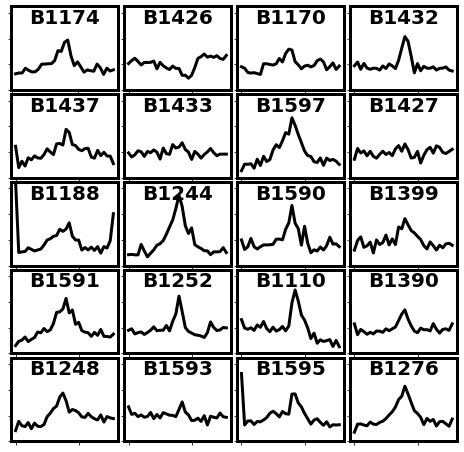

In [31]:
ncols = 4
nrows = 5
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8, 8), gridspec_kw = {'wspace':0.05, 'hspace':0.05})
for axi, subject in enumerate(tqdm(behav_data_all.subject.unique())):
    ax = axs.flatten()[axi]
    behav_data_bird = behav_data_all[behav_data_all.subject == subject]
    sns.lineplot(
        x="interpolation_bin",
        y=rt_column,
        data=behav_data_bird,
        ax=ax,
        ci=None,
        color="k",
        lw=3,
    )
    # ci=None,
    ax.set_ylim([-0.2, 0.45])
    ax.set_xticklabels([])
    #if axi % ncols != 0:
    ax.set_yticklabels([])
    ax.set_ylabel("")
    # if axi < ncols*(nrows-1):
    ax.set_xlabel("")
    ax.text(
        0.5,
        0.8,
        subject,
        horizontalalignment="center",
        fontweight="bold",
        fontsize=20,
        transform=ax.transAxes,
    )

    for axis in ["top", "bottom", "left", "right"]:
        ax.spines[axis].set_linewidth(3)
        ax.spines[axis].set_color("k")

ensure_dir(FIGURE_DIR / 'behavioral_results')
save_fig(FIGURE_DIR / 'behavioral_results' / 'response-time-by-bird', save_pdf=True)
plt.show()

In [32]:
# birds_without_rts = ['B1426', 'B1433', 'B1427'] # 1170

#### Response time vs uncertainty

In [33]:
import lmfit

In [34]:
def residuals(y_true, y_model, x, logscaled=False):
    if logscaled:
        return np.abs(np.log(y_true) - np.log(y_model)) * (1 / (np.log(1 + x)))
    else:
        return np.abs(y_true - y_model)

In [35]:
def model_res(p, x, y, fit, model):
    if fit == "lin":
        return residuals(y, model(p, x), x)
    else:
        return residuals(y, model(p, x), x, logscaled=True)

In [36]:
def exp_decay(p, x):
    return p["e_init"] * np.exp(-x * p["e_decay_const"]) + p["intercept"]

In [37]:
def fit_decay(x, y):
    p_exp = lmfit.Parameters()
    p_exp.add_many(
        ("e_init", 0.05, True, 1e-4, 1),
        ("e_decay_const", 0.1, True, 1e-4, 0.5),
        ("intercept", 0.25, True, -0.5, 2),
    )
    results_exp_min = lmfit.Minimizer(
        model_res, p_exp, fcn_args=(x, y, "lin", exp_decay), nan_policy="omit"
    ).minimize(method="nelder")
    e_init = results_exp_min.params['e_init'].value
    e_decay_const = results_exp_min.params['e_decay_const'].value
    intercept = results_exp_min.params['intercept'].value
    return results_exp_min, e_init, e_decay_const, intercept

In [39]:
behav_data_all['interpolation'] = [i+j for i,j in zip(behav_data_all.left_stim, behav_data_all.right_stim)]

In [40]:
from cdcp.paths import DATA_DIR, ensure_dir

In [41]:
fit_df_interp = pd.read_pickle(DATA_DIR/'behavior'/'fit_df_interp.pickle')

In [42]:
fit_dfs = []
for subject in tqdm(behav_data_all.subject.unique()):
    subject_data = behav_data_all[(behav_data_all.subject == subject)]
    for interpolation in subject_data.interpolation.unique():
        interpolation_data = subject_data[(subject_data.interpolation == interpolation)]
        interpolation_data['distance_from_boundary'] = np.abs(interpolation_data.interpolation_point.values - 63.5)
        
        x = interpolation_data.distance_from_boundary.values.astype(float)
        y = interpolation_data[rt_column].values.astype(float)
        
        # fit model
        results_exp_min, e_init, e_decay_const, intercept = fit_decay(x, y)
        r2 = 1 - np.sum((results_exp_min.residual)**2) / np.sum((y - np.mean(y))**2)
        
        # get model values for x
        x_model = np.linspace(0,63, 1000)
        fit_y = exp_decay(x=x_model, p=results_exp_min.params)
        fit_range = fit_y[0] - intercept
        
        # plot
        if False:
            x_model = np.linspace(1,63, 500)
            
            fit_y = exp_decay(x=x_model, p=results_exp_min.params)
            fig, ax = plt.subplots()
            binned_rt = (
                interpolation_data[["distance_from_boundary", rt_column]]
                .groupby("distance_from_boundary")
                .describe()[rt_column][["mean", "count", "std"]]
                .reset_index()
            )
            ax.scatter(binned_rt.distance_from_boundary.values, binned_rt["mean"].values)
            ax.set_title([subject, interpolation, e_init, e_decay_const, intercept])
            ax.plot(x_model, fit_y, color='k', lw=3)
            #ax.set_ylim([0,2])
            plt.show()
        
        fit_slope = fit_df_interp[(fit_df_interp.cue == 'NC') & (fit_df_interp.bird == subject) & (fit_df_interp.interp == interpolation)]._slope.values[0]
        fit_df = pd.Series(
            {
                'bird': subject,
                'interpolation': interpolation,
                'e_init': e_init,
                'e_decay_const': e_decay_const,
                'intercept': intercept,
                'fit_slope': fit_slope,
                'fit_range': fit_range,
                "r2": r2
            }
        )
        fit_dfs.append(fit_df)
fit_df = pd.concat(fit_dfs, axis=1).T
fit_df[:3]

  0%|          | 0/20 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,bird,interpolation,e_init,e_decay_const,intercept,fit_slope,fit_range,r2
0,B1174,AE,0.181325,0.050766,-0.082308,14.918588,0.181325,0.00243
1,B1174,BF,0.258579,0.15797,-0.039195,18.84814,0.258579,0.00334
2,B1174,BE,0.269816,0.126826,0.008941,2.702706,0.269816,0.003778


In [43]:
fit_df[:3]

,bird,interpolation,e_init,e_decay_const,intercept,fit_slope,fit_range,r2
0,B1174,AE,0.181325,0.050766,-0.082308,14.918588,0.181325,0.00243
1,B1174,BF,0.258579,0.15797,-0.039195,18.84814,0.258579,0.00334
2,B1174,BE,0.269816,0.126826,0.008941,2.702706,0.269816,0.003778


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


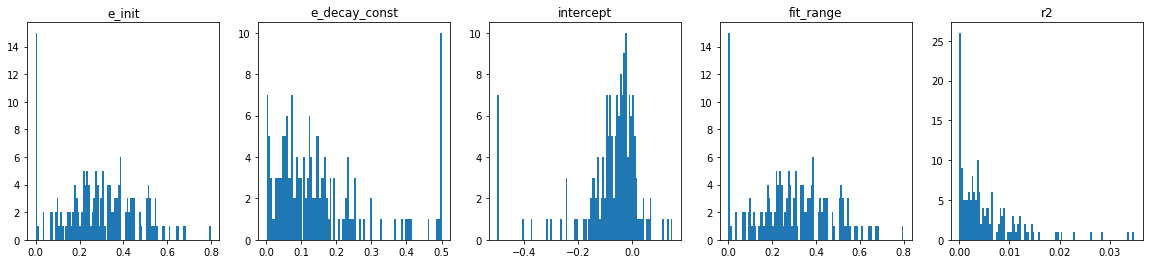

In [44]:
fig, axs = plt.subplots(ncols=5, figsize=(20,4))

for axi, param in enumerate(['e_init', 'e_decay_const', 'intercept', 'fit_range', 'r2']):
    ax = axs[axi]
    ax.set_title(param)
    x = fit_df.fit_slope.values
    y = fit_df[param].values
    ax.hist(y, bins=100)

In [45]:
birds_without_rts = ['B1426', 'B1433', 'B1427']

In [46]:
# normalize log slope by bird, and decay constant by bird
for bird in fit_df.bird.unique():
    m = fit_df.bird == bird
    fit_df.loc[m, 'fit_slope_z'] = z_score(np.log(fit_df[m].fit_slope.values.astype(float)))
    fit_df.loc[m, 'e_decay_const_z'] = z_score(fit_df[m].e_decay_const.values.astype(float))

In [47]:
from cdcp.visualization.utils import get_cat_colors

In [48]:
# remove interpolations without good decay, and birds with no difference in RT
m = (fit_df.fit_range > 0.1) & (fit_df.bird.isin(birds_without_rts) == False) & (fit_df.r2 > 0.001)
fit_df_masked = fit_df[m]

In [49]:
# this percent of interpolations were discluded because we failed to fit a decay
len(fit_df), np.sum(m), np.sum(m)/ len(fit_df)

(165, 121, 0.7333333333333333)

In [79]:
fit_df_masked.interpolation.values

array(['AE', 'BF', 'BE', 'AG', 'CF', 'AF', 'CG', 'BG', 'CE', 'AF', 'BG',
       'BE', 'CF', 'AE', 'BF', 'BE', 'CF', 'CG', 'BG', 'AF', 'AG', 'AE',
       'CE', 'BF', 'AF', 'AE', 'BE', 'CE', 'CF', 'AG', 'CG', 'BG', 'BG',
       'AE', 'BE', 'CG', 'CF', 'CE', 'AF', 'AG', 'BF', 'AF', 'BF', 'BG',
       'AF', 'CF', 'CE', 'BE', 'CG', 'AE', 'BF', 'AG', 'CG', 'BG', 'AE',
       'CF', 'AF', 'BF', 'CE', 'AG', 'BE', 'AE', 'BF', 'AF', 'BE', 'BG',
       'AG', 'CF', 'CG', 'AE', 'CF', 'BG', 'BE', 'AF', 'AG', 'CE', 'BF',
       'AF', 'AE', 'CE', 'CF', 'BG', 'AG', 'BE', 'BF', 'CG', 'CE', 'AE',
       'BG', 'BF', 'AF', 'CG', 'AG', 'CF', 'BF', 'BG', 'AF', 'CE', 'BE',
       'CG', 'BF', 'BE', 'AF', 'AE', 'AF', 'CE', 'AG', 'BG', 'BE', 'BF',
       'CF', 'CG', 'AE', 'AG', 'AF', 'BE', 'BF', 'CE', 'CF', 'BG', 'CG'],
      dtype=object)

In [50]:
colors, pal, pal_dict = get_cat_colors(fit_df_masked.interpolation.values)

In [83]:
pal_dict = {'AE': np.array([0.12156863, 0.46666667, 0.70588235]),
 'AF': np.array([0.58039216, 0.40392157, 0.74117647]),
 'AG': np.array([0.83921569, 0.15294118, 0.15686275]),
 'BE': np.array([0.7372549 , 0.74117647, 0.13333333]),
 'BF': np.array([0.49803922, 0.49803922, 0.49803922]),
 'BG': np.array([0.54901961, 0.3372549 , 0.29411765]),
 'CE': np.array([0.89019608, 0.46666667, 0.76078431]),
 'CF': np.array([0.17254902, 0.62745098, 0.17254902]),
 'CG': np.array([1.        , 0.49803922, 0.05490196])}

In [88]:
colors = [pal_dict[i] for i in fit_df_masked.interpolation.values]

In [89]:
x = fit_df_masked["fit_slope_z"].values.astype(float)
y = fit_df_masked["e_decay_const_z"].values.astype(float)

In [90]:
len(x)

121

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


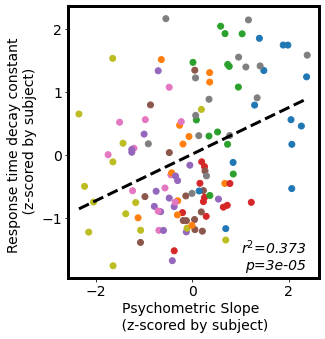

In [92]:
fig, ax = plt.subplots(figsize=(4.5,5))
ax.scatter(x, y, c = colors)
ax.set_xlabel('Psychometric Slope \n (z-scored by subject)', fontsize=14)
ax.set_ylabel('Response time decay constant \n (z-scored by subject)', fontsize=14)
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color("k")
ax.tick_params(axis="both", labelsize=14, pad=15)

m, b = np.polyfit(x, y, 1)

x_line = np.linspace(np.min(x), np.max(x), 100)
plt.plot(x_line, m*x_line + b, color ='k', ls='dashed', lw=3)

correlation_sigma, p_value_sigma = scipy.stats.pearsonr(x,y)

ax.text(
    0.95,
    0.15,
    "r$^2$={}\np={:g}".format(round(correlation_sigma, 3), float('{:.1g}'.format(p_value_sigma))),
    horizontalalignment="right",
    verticalalignment="top",
    fontsize=14,
    color='k',
    #fontweight='bold',
    style='italic',
    transform=ax.transAxes
);
ax.set_yticks([-1, 0, 1, 2])
ax.yaxis.labelpad = 4
for tick in ax.get_yaxis().get_major_ticks():
    tick.set_pad(2.)
ax.xaxis.labelpad = 4
for tick in ax.get_xaxis().get_major_ticks():
    tick.set_pad(2.)

    
ensure_dir(FIGURE_DIR / 'behavioral_results')
save_fig(FIGURE_DIR / 'behavioral_results' / 'response-time-vs-psychometric', save_pdf=True)
plt.show()

### Response time by cue class

In [55]:
behav_data_all[:3]

,session,index,type_,stimulus,class_,response,correct,rt,reward,punish,cue_class,cue_id,cue_prob,num_stims,flip_cues,binary_choice,cueing,left_stim,right_stim,interpolation_point,prob_cue,prob_cued_no_cue,data_file,response_bool,interpolation,pos_bin,cue_direction,subject,self_initiated,normed_rt,normed_rt_decision,normed_rt_class,interpolation_bin
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-24 14:44:30.569983,709,52,normal,/home/bird/opdat/B1174/stimuli/AE/CL1/CL1_AE_1...,L,L,True,0.078940,False,False,CL,CL1,0.875,3,False,False,True,A,E,20,0.8,0.2,/mnt/cube/RawData/Magpi/B1174/B1174_trialdata_...,0,AE,5,L,B1174,NaN,NaN,-0.547038,-0.548247,5
2019-12-24 14:44:35.027883,709,53,normal,/home/bird/opdat/B1174/stimuli/BF/NC/NC_BF_110...,L,L,True,0.391212,False,False,NC,NC,0.500,3,False,False,True,B,F,17,0.8,0.2,/mnt/cube/RawData/Magpi/B1174/B1174_trialdata_...,0,BF,5,N,B1174,NaN,NaN,-0.024007,-0.017190,5
2019-12-24 14:44:38.697615,709,54,normal,/home/bird/opdat/B1174/stimuli/BE/CL1/CL1_BE_0...,L,L,True,0.000671,True,False,CL,CL1,0.875,3,False,False,True,B,E,40,0.8,0.2,/mnt/cube/RawData/Magpi/B1174/B1174_trialdata_...,0,BE,10,L,B1174,NaN,NaN,-0.678132,-0.681353,10


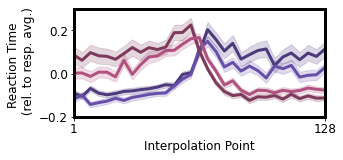

In [74]:
fig, ax = plt.subplots(figsize=(4.5,2))
sns.lineplot(
    x="interpolation_bin",
    y="normed_rt_class",
    hue="cue_id",
    data=behav_data_all[behav_data_all.cue_class.isin(["CL", "CR"])],
    #order = ['CL1', 'CL0', 'CR1', 'CR0'],
    palette = cdcp_colors["cue_pal"],
    #ci=None,
    legend=False,
    ax = ax,
    lw=3
)

for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color("k")
ax.tick_params(axis="both", labelsize=12, pad=15)

ax.set_xticks([1, 31])
ax.set_xticklabels([1, 128])
ax.set_xlabel('Interpolation Point', fontsize=12)
ax.set_ylabel('Reaction Time \n (rel. to resp. avg.)', fontsize=12)
ax.yaxis.labelpad = 4
for tick in ax.get_yaxis().get_major_ticks():
    tick.set_pad(2.)
ax.xaxis.labelpad = 4
for tick in ax.get_xaxis().get_major_ticks():
    tick.set_pad(2.)

    
ax.set_xlim([1,31])
ax.set_ylim([-0.2, 0.3])
ensure_dir(FIGURE_DIR / 'behavioral_results')
save_fig(FIGURE_DIR / 'behavioral_results' / 'response-time-vs-cue-prob-short', save_pdf=True)
plt.show()

### Contrast with prior probability

In [57]:
from joblib import Parallel, delayed
from cdcp.behavior.bayesian import fit_bayesian_model, bayesian_model

In [58]:
params = {
    'sigma_likelihood':10, # std of gaussian for likelihood
    'beta_categorical_attention': 0, # pct of time ignoring the categorical stimulus # if set at 0 all guesses are based upon the cue, 
    'delta_cue_attention':.1, # pct of time ignoring the cue
    'alpha_overall_attention':.2, # pct of time ingoring both the cue, and categorical stimulis, independant of the product of beta and delta 
    'gamma_side_bias': .5 # the direction of the random guess (side bias)
}

In [59]:
x_true = np.arange(128)
decision_boundary = np.zeros(len(x_true))
decision_boundary[x_true > 63] = 1

In [60]:
condition_types = [0.125, 0.25, 0.5, 0.75, 0.875]
midpoint = 63
prior_probability = {ct: np.zeros(len(x_true))+ct for ct in condition_types}
for ct in condition_types: prior_probability[ct][x_true > midpoint]  = 1-ct 

/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


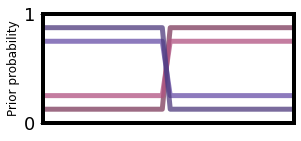

In [61]:
fig, ax = plt.subplots(figsize=(4.5,2))

cue_plots = []

# plot
for ct in [0.125, 0.25, 0.75, 0.875]:
    decision, posterior_probability, likelihood = bayesian_model(params, x_true, prior_probability[ct], decision_boundary)
    ax.plot(x_true[::4],prior_probability[ct][::4], color = cdcp_colors['cue']['L'][ct], label = ct, lw = 5, alpha = 0.75)

#ax.set_xlabel('Interpolation point ($x_{true}$)')
ax.set_xticks([], [])
ax.set_yticks([0,1])

ax.set_ylabel('Prior probability', fontsize=12)
[i.set_linewidth(4) for i in ax.spines.values()]
plt.tick_params(axis='both', which='major', labelsize=18)

ax.set_xlim([0,126])   
ax.set_ylim([0,1])
# legends
#ax.legend()
ensure_dir(FIGURE_DIR / 'behavioral_results')
save_fig(FIGURE_DIR / 'behavioral_results' / 'prior_short', save_pdf=True)
plt.show()


### Correlation between reaction time and prior probability for each interpolation point

In [62]:
behav_data_all[:3]

,session,index,type_,stimulus,class_,response,correct,rt,reward,punish,cue_class,cue_id,cue_prob,num_stims,flip_cues,binary_choice,cueing,left_stim,right_stim,interpolation_point,prob_cue,prob_cued_no_cue,data_file,response_bool,interpolation,pos_bin,cue_direction,subject,self_initiated,normed_rt,normed_rt_decision,normed_rt_class,interpolation_bin
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-24 14:44:30.569983,709,52,normal,/home/bird/opdat/B1174/stimuli/AE/CL1/CL1_AE_1...,L,L,True,0.078940,False,False,CL,CL1,0.875,3,False,False,True,A,E,20,0.8,0.2,/mnt/cube/RawData/Magpi/B1174/B1174_trialdata_...,0,AE,5,L,B1174,NaN,NaN,-0.547038,-0.548247,5
2019-12-24 14:44:35.027883,709,53,normal,/home/bird/opdat/B1174/stimuli/BF/NC/NC_BF_110...,L,L,True,0.391212,False,False,NC,NC,0.500,3,False,False,True,B,F,17,0.8,0.2,/mnt/cube/RawData/Magpi/B1174/B1174_trialdata_...,0,BF,5,N,B1174,NaN,NaN,-0.024007,-0.017190,5
2019-12-24 14:44:38.697615,709,54,normal,/home/bird/opdat/B1174/stimuli/BE/CL1/CL1_BE_0...,L,L,True,0.000671,True,False,CL,CL1,0.875,3,False,False,True,B,E,40,0.8,0.2,/mnt/cube/RawData/Magpi/B1174/B1174_trialdata_...,0,BE,10,L,B1174,NaN,NaN,-0.678132,-0.681353,10


In [63]:
p_dict = {
    'L': {
        'CL1':0.875, 'NC':0.5, 'CL0':0.75, 'CR1':0.125, 'CR0':0.25, 'CN':0.5
    },
    'R': {
        'CL1':0.125, 'NC':0.5, 'CL0':0.25, 'CR1':0.875, 'CR0':0.75, 'CN':0.5
    }
}

In [64]:
behav_data_all.cue_id.unique()

array(['CL1', 'NC', 'CL0', 'CR1', 'CR0', 'CN'], dtype=object)

In [65]:
len(behav_data_all)

1979805

In [66]:
def get_dict(class_, id_):
    return p_dict[class_][id_]
cued_class_prob = behav_data_all.apply(lambda row: get_dict(row['class_'], row['cue_id']), axis=1).values

In [67]:
np.unique(cued_class_prob, return_counts=True)

(array([0.125, 0.25 , 0.5  , 0.75 , 0.875]),
 array([112319, 207768, 474169, 551684, 633865]))

In [68]:
{i:np.mean(behav_data_all.normed_rt_class.values[cued_class_prob == i]) for i in np.unique(cued_class_prob)}

{0.125: 0.1207183550434856,
 0.25: 0.053523914075653496,
 0.5: 0.12119352624560954,
 0.75: -0.0660620482313852,
 0.875: -0.07209793825131623}

In [69]:
x = cued_class_prob

In [70]:
y = behav_data_all.normed_rt_class.values

In [71]:
len(x)

1979805

In [72]:
scipy.stats.pearsonr(x,y)

(-0.07233026890913757, 0.0)